### LICENSE PLACE DETECTION AND RECOGNITION

In [1]:
# !pip install albumentations==0.4.6



In [2]:
import cv2
import ast

import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

from sklearn import model_selection

import random

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from tqdm.notebook import tqdm

import warnings
import os
import random
warnings.filterwarnings("ignore")
from glob import glob
import xml.etree.ElementTree as xet
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [4]:
path = glob("../input/car-plate-detection/annotations/*.xml")
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])

for filename in path:
    data = xet.parse(filename)
    root = data.getroot()
    obj = root.find('object')
    labels_info = obj.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [5]:
valid_df = pd.DataFrame(labels_dict)
valid_df.to_csv('labels.csv',index=False)
valid_df.head()

,filepath,xmin,xmax,ymin,ymax
0,../input/car-plate-detection/annotations/Cars3...,209,283,135,169
1,../input/car-plate-detection/annotations/Cars1...,191,242,147,169
2,../input/car-plate-detection/annotations/Cars7...,115,277,115,153
3,../input/car-plate-detection/annotations/Cars1...,36,62,175,186
4,../input/car-plate-detection/annotations/Cars2...,71,215,205,246


In [6]:
valid_df['filepath'] = valid_df['filepath'].str.replace('../input/car-plate-detection/annotations/','')
valid_df['filepath'] = valid_df['filepath'].str.replace('.xml','.png')
valid_df['class'] = 'license'
valid_df = valid_df.rename(columns = {'filepath':'img_id'})
valid_df.head()

,img_id,xmin,xmax,ymin,ymax,class
0,Cars339.png,209,283,135,169,license
1,Cars13.png,191,242,147,169,license
2,Cars74.png,115,277,115,153,license
3,Cars16.png,36,62,175,186,license
4,Cars291.png,71,215,205,246,license


In [7]:
df = pd.read_csv('/kaggle/input/license-plates/license_plates_detection_train.csv')
df['class'] = 'license'
df.head()

,img_id,ymin,xmin,ymax,xmax,class
0,1.jpg,276,94,326,169,license
1,10.jpg,311,395,344,444,license
2,100.jpg,406,263,450,434,license
3,101.jpg,283,363,315,494,license
4,102.jpg,139,42,280,222,license


In [8]:
df.shape, valid_df.shape

((900, 6), (433, 6))

In [9]:
classes_la = {"license": 1}

df["class"] = df["class"].apply(lambda x: classes_la[x])
valid_df["class"] = valid_df["class"].apply(lambda x: classes_la[x])

### Plotting the Images

In [10]:
# group by all bounding boxes (bbox)
df_grp = df.groupby(['img_id'])
df_grp

In [11]:
path = '/kaggle/input/license-plates/license_plates/license_plates/license_plates_detection_train/license_plates_detection_train/'
def plot_image(image_name):
    image_group = df_grp.get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    img = immg.imread(path+name)
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(bbox)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()


   xmin  ymin  xmax  ymax
0    94   276   169   326


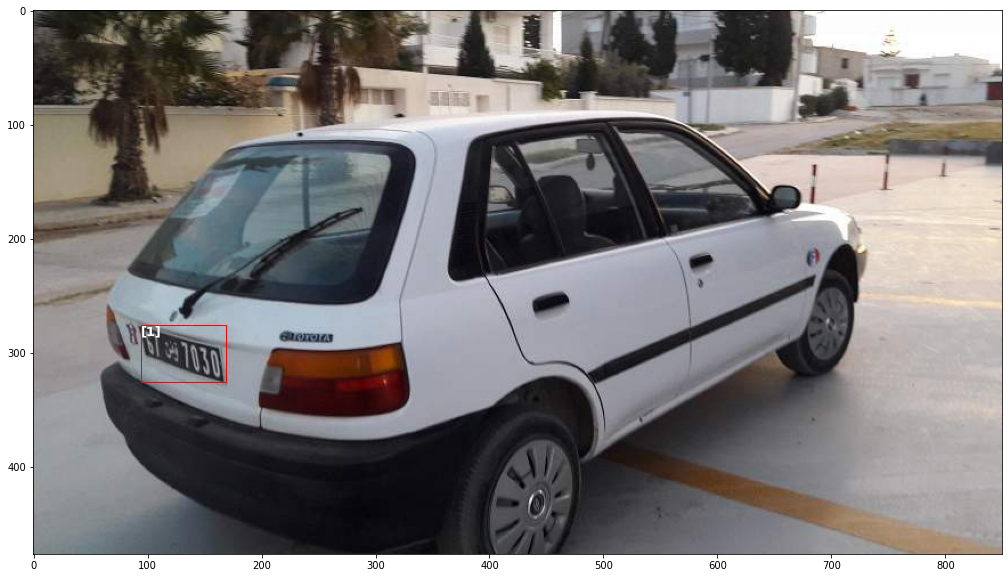

In [12]:
name = df.img_id.unique()[0]
plot_image(name)

     xmin  ymin  xmax  ymax
700   417   173   443   250


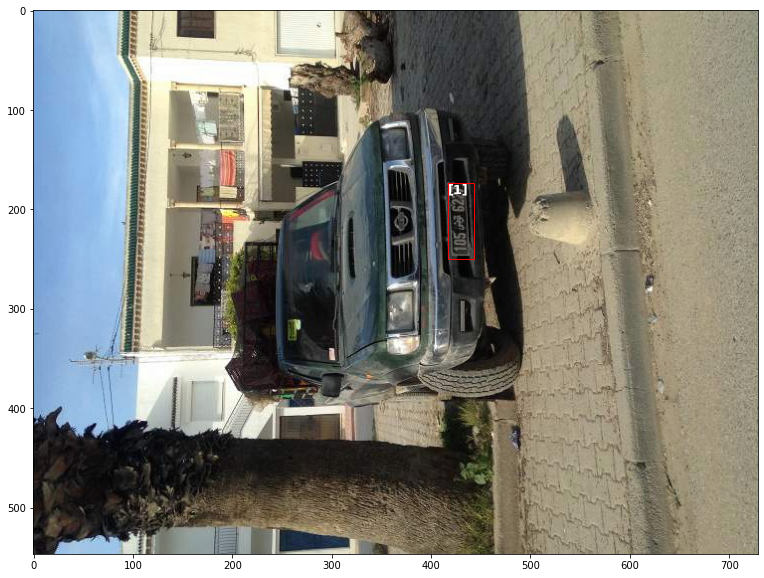

In [13]:
name = df.img_id.unique()[700]
plot_image(name)

    xmin  ymin  xmax  ymax
67   255   314   428   359


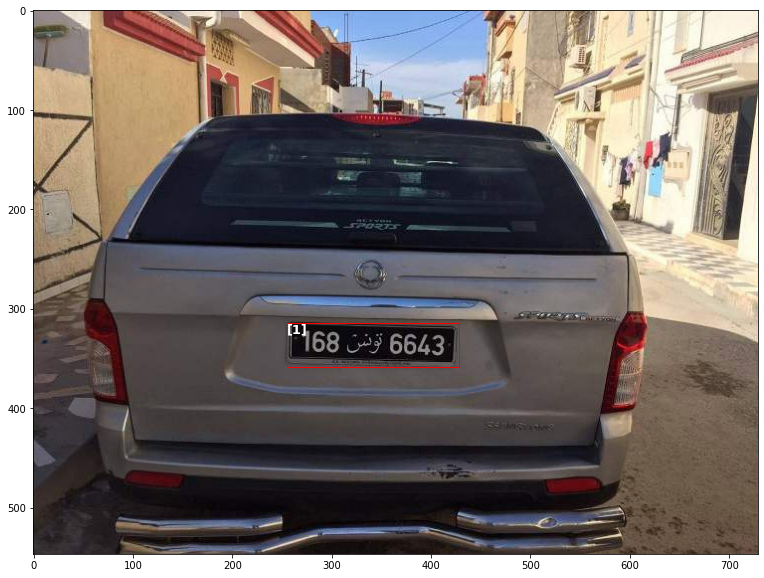

In [14]:
name = df.img_id.unique()[67]
plot_image(name)

### Create a Custom Dataset

In [15]:
class LicensePlate(object):
    def __init__(self, df, IMG_DIR, transforms):
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df.img_id.unique()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_values = self.df[self.df['img_id'] == image_id]
        image = cv2.imread(self.img_dir+image_id,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=255.0
        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = image_values["class"].values
        labels = torch.tensor(labels)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)        
        
        if self.transforms:
            sample = {
                'image':image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            
        sample = self.transforms(**sample)
        image = sample['image']
        target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        
        return torch.tensor(image), target, image_id
        


### AUGMENTATIONS

In [16]:
def get_train_transform():
    return A.Compose([
        A.Resize(512,512),
        A.Transpose(),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.1,0.1), 
            contrast_limit=(-0.1, 0.1), 
            p=0.5
        ),
        A.HueSaturationValue(
            hue_shift_limit=0.2, 
            sat_shift_limit=0.2, 
            val_shift_limit=0.2, 
            p=0.5
            ), 
        A.Blur(p=0.5),


        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Resize(512, 512), 
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### LOAD LICENSE PLATE DATASET AND PERFORM THE TRANSFORMATIONS

In [17]:
license_dataset = LicensePlate(df, path, get_train_transform())

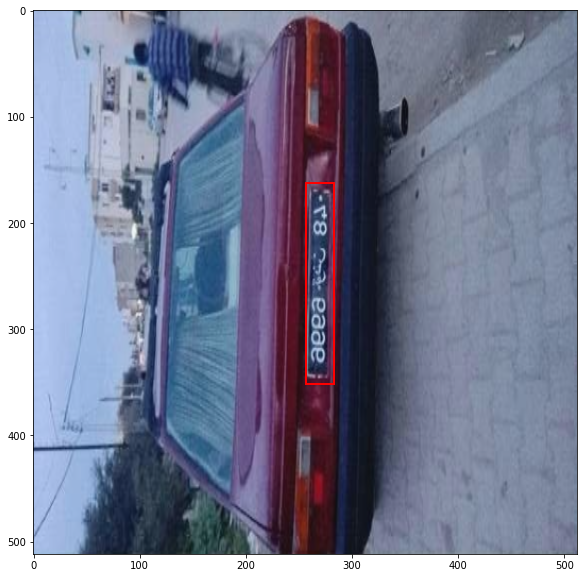

In [18]:
img, tar, _ = license_dataset[random.randint(0,906)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in tar["labels"].tolist():
    classes_la = {1:"license"}
    l = classes_la[l]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
#         ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold') # Useful if you have many classes
        ax.add_patch(rect)
    plt.show()


### Split data into Train and Test

In [19]:
display(df.head(),
        df.shape,
        valid_df.head(),
        valid_df.shape)

,img_id,ymin,xmin,ymax,xmax,class
0,1.jpg,276,94,326,169,1
1,10.jpg,311,395,344,444,1
2,100.jpg,406,263,450,434,1
3,101.jpg,283,363,315,494,1
4,102.jpg,139,42,280,222,1


(900, 6)

,img_id,xmin,xmax,ymin,ymax,class
0,Cars339.png,209,283,135,169,1
1,Cars13.png,191,242,147,169,1
2,Cars74.png,115,277,115,153,1
3,Cars16.png,36,62,175,186,1
4,Cars291.png,71,215,205,246,1


(433, 6)

### DATALOADER

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))
valid_path = '/kaggle/input/car-plate-detection/images/'

train_dataset = LicensePlate(df, path, get_train_transform())
valid_dataset = LicensePlate(valid_df, valid_path, get_valid_transform())

#split the dataset into train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size = 8,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 8,
    shuffle = False,
    num_workers = 4,
    collate_fn = collate_fn
)

### model

In [21]:
num_classes = 2 #because we have to add the background class to the license plate

# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
num_epochs = 10

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [22]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_data_loader)*num_epochs)


### Training and Evaluation

In [ ]:
import sys
best_epoch = 0
min_loss = sys.maxsize
best_IOU =0.5
es_patience = 3

for epoch in range(num_epochs):
    tk = tqdm(train_data_loader)
    model.train(); #training mode
    for images, targets, image_ids in tk:
        images = list(image.to(device) for image in images )
        targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tk.set_postfix(train_loss = loss_value)
    tk.close()
    
    #update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
        
    print(f"Epoch #{epoch} loss: {loss_value}") 
    
    #validation
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_data_loader)
        for images, targets, image_ids in tk:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to('cpu') for k, v in t.items()} for t in val_output]
            IOU = []
            
            for j in range(len(val_output)):
                a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()
        print(res)
        if res > best_IOU:
            best_IOU = res
            patience = es_patience
            # Resetting patience since we have new best validation accuracy
            print(" Saving the best model")
            torch.save(model.state_dict(),f'best_fasterrcnn_updated.pth')  # Saving current best model
                    
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping. Best Val IOU: {:.3f}'.format(best_IOU))
                break               

            
                
            
        
        

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch #0 loss: 0.05169462040066719


  0%|          | 0/55 [00:00<?, ?it/s]

0.8069584317998291
 Saving the best model


  0%|          | 0/113 [00:00<?, ?it/s]

Epoch #1 loss: 0.04705136641860008


  0%|          | 0/55 [00:00<?, ?it/s]

0.9201030922153591
 Saving the best model


  0%|          | 0/113 [00:00<?, ?it/s]

### Evaluation on sample image

In [ ]:
img,target,_ = valid_dataset[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))

print('real #boxes: ', len(target['boxes']))

### Ground truth box for the sample valid image

In [ ]:
bbox = target['boxes'].numpy()
fig,ax = plt.subplots(1,figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for l in target["labels"]:
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
#         ax.text(*box[:2], l.tolist(), verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

### Predicted box for the sample valid Image

In [ ]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = img.permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    val_scores = prediction['scores'].cpu().detach().numpy()
    bbox = prediction['boxes'].cpu().detach().numpy()
    for l in target["labels"]:
        for i in range(len(bbox)):
            if val_scores[i]>=detect_thresh:
                box = bbox[i]
                x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
                rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
#                 ax.text(*box[:2], "class " + str(l.tolist()) + " score {0:.3f}".format(val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
                ax.add_patch(rect)
        plt.show()

In [ ]:
plot_valid(img,prediction)

### Loading The Test Images

In [ ]:
submission = pd.read_csv('/kaggle/input/license-plates/license_plates/license_plates/SampleSubmission.csv')
submission['img_id'] = submission['id'].str.extract(r'img_(\d+)_\d+')
sub = submission[['img_id']]
sub = sub.drop_duplicates().reset_index(drop=True)
sub.head()

In [ ]:
class One_Image(object):
    def __init__(self,IMG_PATH, transforms):        
        
        self.img_path = IMG_PATH
        self.transforms = transforms

    
    def __getitem__(self, idx=0):        
        image = cv2.imread(self.img_path,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']
        return image

In [ ]:
IMG_SIZE = (512,512)
def get_test_transform(IMG_SIZE=(512,512)):
    return A.Compose([
         A.Resize(*IMG_SIZE),
         A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        
        ToTensorV2(p=1.0)
    ])

In [ ]:
test_path = '/kaggle/input/license-plates/license_plates/license_plates/test/test_private/'
one_dataset = One_Image(test_path + sub.img_id[random.randint(0,200)], get_test_transform())
one_dataset

### Plot the predicted test Image

In [ ]:
img = one_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))

In [ ]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = one_dataset[0].permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    val_scores = prediction['scores'].cpu().detach().numpy()
    bbox = prediction['boxes'].cpu().detach().numpy()
    
    for i in range(len(bbox)):
        if val_scores[i]>=detect_thresh:
            box = bbox[i]
            x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
#             ax.text(*box[:2], "class " + str(l.tolist()) + " score {0:.3f}".format(val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
            ax.add_patch(rect)
    plt.show()

## Extracting text using OCR

In [ ]:
!pip install pytesseract

In [ ]:
import numpy as np
import cv2
import pytesseract

def plot_test(img,prediction,nms=True,detect_thresh=0.7):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = one_dataset[0].permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    val_scores = prediction['scores'].cpu().detach().numpy()
    bbox = prediction['boxes'].cpu().detach().numpy()
    
    for i in range(len(bbox)):
        if val_scores[i]>=detect_thresh:
            box = bbox[i]
            x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
            ax.add_patch(rect)
            
            # extract the number plate region from the image
            plate_img = img[int(y):int(y+h), int(x):int(x+w), :]
            
            # convert the number plate image to grayscale
            plate_img = np.array(plate_img) # convert to numpy array
            gray_plate_img = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
            
            # apply binary thresholding to the grayscale image
            thresh_plate_img = cv2.threshold(gray_plate_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
            
            # use PyTesseract to read the text in the number plate
            plate_text = pytesseract.image_to_string(thresh_plate_img, config='--psm 11')
            
            # display the text in the number plate
            ax.text(x, y-10, plate_text, color='w', fontsize=12, weight='bold')
    
    plt.show()

plot_test(img, prediction)
